In [21]:
import time
from lxml import etree

dump_file = "../../data/wikipedia/iswiki-20240901-pages-articles.xml"

In [23]:
import xml.sax
from collections import Counter


class WikiXMLHandler(xml.sax.ContentHandler):
    def __init__(self, max_pages=None):
        super().__init__()
        self.current_data = ""
        self.page_id = None
        self.title = None
        self.ns = None
        self.text = None
        self.in_page = False
        self.in_revision = False
        self.page_count = Counter()
        self.max_pages = max_pages
        self.processed_ids = set()

    def startElement(self, tag, attributes):
        self.current_data = ""
        if tag == "page":
            self.in_page = True
        elif tag == "revision":
            self.in_revision = True

    def endElement(self, tag):
        if tag == "id" and self.in_page and not self.in_revision:
            self.page_id = int(self.current_data)
        elif tag == "title":
            self.title = self.current_data
        elif tag == "ns":
            self.ns = int(self.current_data)
        elif tag == "text" and self.in_revision:
            self.text = self.current_data
        elif tag == "page":
            self.process_page()
            self.reset_page_data()
            if self.max_pages and sum(self.page_count.values()) >= self.max_pages:
                raise StopIteration("Reached maximum number of pages")
        elif tag == "revision":
            self.in_revision = False

    def characters(self, content):
        self.current_data += content

    def process_page(self):
        if self.ns == 0 and self.page_id not in self.processed_ids:  # Main articles
            self.processed_ids.add(self.page_id)
            if self.text and not self.text.lower().startswith("#redirect"):
                # This is a content page, not a redirect
                self.page_count["content"] += 1
                # Here you would create and store your embedding
                # print(f"Processed article for embedding: {self.title} (ID: {self.page_id})")
                # create_and_store_embedding(self.title, self.text)
            else:
                self.page_count["redirect"] += 1

            if sum(self.page_count.values()) % 1000 == 0:
                print(
                    f"Processed {sum(self.page_count.values())} pages "
                    f"(Content: {self.page_count['content']}, "
                    f"Redirects: {self.page_count['redirect']})"
                )

    def reset_page_data(self):
        self.page_id = None
        self.title = None
        self.ns = None
        self.text = None


def process_wikipedia_dump(file_path, max_pages=None):
    handler = WikiXMLHandler(max_pages)
    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    try:
        parser.parse(file_path)
    except StopIteration:
        print("Reached maximum number of pages")
    except Exception as e:
        print(f"Error parsing XML: {e}")
    finally:
        print(f"Total pages processed: {sum(handler.page_count.values())}")
        print(f"Content pages: {handler.page_count['content']}")
        print(f"Redirect pages: {handler.page_count['redirect']}")


# Usage
process_wikipedia_dump(
    dump_file, max_pages=1000
)  # Set max_pages to None to process all pages

Processed 1000 pages (Content: 887, Redirects: 113)
Reached maximum number of pages
Total pages processed: 1000
Content pages: 887
Redirect pages: 113


# Metadaa to analyze the dump

In [ ]:
import xml.sax
from collections import Counter
import pandas as pd
import re
from urllib.parse import quote


class WikiXMLHandler(xml.sax.ContentHandler):
    def __init__(self, max_pages=None):
        super().__init__()
        self.current_data = ""
        self.page_id = None
        self.title = None
        self.ns = None
        self.text = None
        self.timestamp = None
        self.in_page = False
        self.in_revision = False
        self.page_count = Counter()
        self.max_pages = max_pages
        self.processed_ids = set()
        self.metadata = []

    def startElement(self, tag, attributes):
        self.current_data = ""
        if tag == "page":
            self.in_page = True
        elif tag == "revision":
            self.in_revision = True

    def endElement(self, tag):
        if tag == "id" and self.in_page and not self.in_revision:
            self.page_id = int(self.current_data)
        elif tag == "title":
            self.title = self.current_data
        elif tag == "ns":
            self.ns = int(self.current_data)
        elif tag == "text" and self.in_revision:
            self.text = self.current_data
        elif tag == "timestamp" and self.in_revision:
            self.timestamp = self.current_data
        elif tag == "page":
            self.process_page()
            self.reset_page_data()
            if self.max_pages and sum(self.page_count.values()) >= self.max_pages:
                raise StopIteration("Reached maximum number of pages")
        elif tag == "revision":
            self.in_revision = False

    def characters(self, content):
        self.current_data += content

    def process_page(self):
        if self.ns == 0 and self.page_id not in self.processed_ids:  # Main articles
            self.processed_ids.add(self.page_id)
            if self.text and not self.text.lower().startswith("#redirect"):
                # This is a content page, not a redirect
                self.page_count["content"] += 1

                # Calculate metadata
                word_count = len(self.text.split())
                outlink_count = len(re.findall(r"\[\[([^\]]+)\]\]", self.text))
                categories = re.findall(r"\[\[Category:([^\]]+)\]\]", self.text)

                # Generate URL
                url = f"https://en.wikipedia.org/wiki/{quote(self.title.replace(' ', '_'))}"

                # Store metadata
                self.metadata.append(
                    {
                        "page_id": self.page_id,
                        "title": self.title,
                        "url": url,
                        "word_count": word_count,
                        "outlink_count": outlink_count,
                        "category_count": len(categories),
                        "categories": "|".join(categories),
                        "last_modified": self.timestamp,
                    }
                )
            else:
                self.page_count["redirect"] += 1

            if sum(self.page_count.values()) % 1000 == 0:
                print(
                    f"Processed {sum(self.page_count.values())} pages "
                    f"(Content: {self.page_count['content']}, "
                    f"Redirects: {self.page_count['redirect']})"
                )

    def reset_page_data(self):
        self.page_id = None
        self.title = None
        self.ns = None
        self.text = None
        self.timestamp = None


def process_wikipedia_dump(file_path, max_pages=None):
    handler = WikiXMLHandler(max_pages)
    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    try:
        parser.parse(file_path)
    except StopIteration:
        print("Reached maximum number of pages")
    except Exception as e:
        print(f"Error parsing XML: {e}")
    finally:
        print(f"Total pages processed: {sum(handler.page_count.values())}")
        print(f"Content pages: {handler.page_count['content']}")
        print(f"Redirect pages: {handler.page_count['redirect']}")

        # Create DataFrame from collected metadata
        df = pd.DataFrame(handler.metadata)
        return df


# Usage
df = process_wikipedia_dump(dump_file, max_pages=1000)

# # Basic analysis
# print(df.describe())

# # Top 10 articles by word count
# print(df.nlargest(10, 'word_count')[['title', 'word_count']])

# # Top 10 articles by outlink count
# print(df.nlargest(10, 'outlink_count')[['title', 'outlink_count']])

# # Distribution of category counts
# print(df['category_count'].value_counts().sort_index())

print(len(df))
df.head()

# With graph analysis

In [36]:
import xml.sax
from collections import Counter
import pandas as pd
import re
from urllib.parse import quote
import networkx as nx
import matplotlib.pyplot as plt


class WikiXMLHandler(xml.sax.ContentHandler):
    def __init__(self, max_pages=None):
        super().__init__()
        self.current_data = ""
        self.page_id = None
        self.title = None
        self.ns = None
        self.text = None
        self.timestamp = None
        self.in_page = False
        self.in_revision = False
        self.page_count = Counter()
        self.max_pages = max_pages
        self.processed_ids = set()
        self.metadata = []
        self.graph = nx.DiGraph()

    def startElement(self, tag, attributes):
        self.current_data = ""
        if tag == "page":
            self.in_page = True
        elif tag == "revision":
            self.in_revision = True

    def endElement(self, tag):
        if tag == "id" and self.in_page and not self.in_revision:
            self.page_id = int(self.current_data)
        elif tag == "title":
            self.title = self.current_data
        elif tag == "ns":
            self.ns = int(self.current_data)
        elif tag == "text" and self.in_revision:
            self.text = self.current_data
        elif tag == "timestamp" and self.in_revision:
            self.timestamp = self.current_data
        elif tag == "page":
            self.process_page()
            self.reset_page_data()
            if self.max_pages and sum(self.page_count.values()) >= self.max_pages:
                raise StopIteration("Reached maximum number of pages")
        elif tag == "revision":
            self.in_revision = False

    def characters(self, content):
        self.current_data += content

    def process_page(self):
        if self.ns == 0 and self.page_id not in self.processed_ids:  # Main articles
            self.processed_ids.add(self.page_id)
            if self.text and not self.text.lower().startswith("#redirect"):
                # This is a content page, not a redirect
                self.page_count["content"] += 1

                # Calculate metadata
                word_count = len(self.text.split())
                outlinks = re.findall(r"\[\[([^|\]]+)", self.text)
                outlink_count = len(outlinks)
                categories = re.findall(r"\[\[Category:([^\]]+)\]\]", self.text)

                # Generate URL
                url = f"https://en.wikipedia.org/wiki/{quote(self.title.replace(' ', '_'))}"

                # Store metadata
                self.metadata.append(
                    {
                        "page_id": self.page_id,
                        "title": self.title,
                        "url": url,
                        "word_count": word_count,
                        "outlink_count": outlink_count,
                        "category_count": len(categories),
                        "categories": "|".join(categories),
                        "last_modified": self.timestamp,
                    }
                )

                # Update graph
                self.graph.add_node(self.title, word_count=word_count)
                for outlink in outlinks:
                    self.graph.add_edge(self.title, outlink)

            else:
                self.page_count["redirect"] += 1

            if sum(self.page_count.values()) % 1000 == 0:
                print(
                    f"Processed {sum(self.page_count.values())} pages "
                    f"(Content: {self.page_count['content']}, "
                    f"Redirects: {self.page_count['redirect']})"
                )

    def reset_page_data(self):
        self.page_id = None
        self.title = None
        self.ns = None
        self.text = None
        self.timestamp = None


def process_wikipedia_dump(file_path, max_pages=None):
    handler = WikiXMLHandler(max_pages)
    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    try:
        parser.parse(file_path)
    except StopIteration:
        print("Reached maximum number of pages")
    except Exception as e:
        print(f"Error parsing XML: {e}")
    finally:
        print(f"Total pages processed: {sum(handler.page_count.values())}")
        print(f"Content pages: {handler.page_count['content']}")
        print(f"Redirect pages: {handler.page_count['redirect']}")

        # Create DataFrame from collected metadata
        df = pd.DataFrame(handler.metadata)
        return df, handler.graph


# Usage
# dump_file = 'path_to_your_wikipedia_dump.xml'
df, graph = process_wikipedia_dump(dump_file, max_pages=1000000)

Processed 1000 pages (Content: 887, Redirects: 113)
Processed 2000 pages (Content: 1746, Redirects: 254)
Processed 3000 pages (Content: 2505, Redirects: 495)
Processed 4000 pages (Content: 2558, Redirects: 1442)
Processed 5000 pages (Content: 3099, Redirects: 1901)
Processed 6000 pages (Content: 4052, Redirects: 1948)
Processed 7000 pages (Content: 5033, Redirects: 1967)
Processed 8000 pages (Content: 6033, Redirects: 1967)
Processed 9000 pages (Content: 7032, Redirects: 1968)
Processed 10000 pages (Content: 8032, Redirects: 1968)
Processed 11000 pages (Content: 8935, Redirects: 2065)
Processed 12000 pages (Content: 9895, Redirects: 2105)
Processed 13000 pages (Content: 10867, Redirects: 2133)
Processed 14000 pages (Content: 11846, Redirects: 2154)
Processed 15000 pages (Content: 12731, Redirects: 2269)
Processed 16000 pages (Content: 13659, Redirects: 2341)
Processed 17000 pages (Content: 14627, Redirects: 2373)
Processed 18000 pages (Content: 15614, Redirects: 2386)
Processed 19000 p


Graph Analysis:
Number of nodes: 391162
Number of edges: 1333275

Top 20 articles by in-degree centrality (most linked-to):
Jurtaríki: centrality = 0.0110, in-links = 4300
Bandaríkin: centrality = 0.0106, in-links = 4161
Ísland: centrality = 0.0104, in-links = 4085
fræðiheiti: centrality = 0.0089, in-links = 3491
Dulfrævingar: centrality = 0.0088, in-links = 3454
Tvíkímblöðungar: centrality = 0.0067, in-links = 2612
Reykjavík: centrality = 0.0058, in-links = 2274
Frakkland: centrality = 0.0057, in-links = 2231
Þýskaland: centrality = 0.0052, in-links = 2026
Bretland: centrality = 0.0049, in-links = 1907
Dýraríki: centrality = 0.0047, in-links = 1848
Svíþjóð: centrality = 0.0046, in-links = 1781
Flokkur:Íslensk kvenmannsnöfn: centrality = 0.0045, in-links = 1748
íslenskt kvenmannsnafn: centrality = 0.0044, in-links = 1738
England: centrality = 0.0044, in-links = 1712
Flokkur:Íslensk karlmannsnöfn: centrality = 0.0042, in-links = 1650
íslenskt karlmannsnafn: centrality = 0.0042, in-link

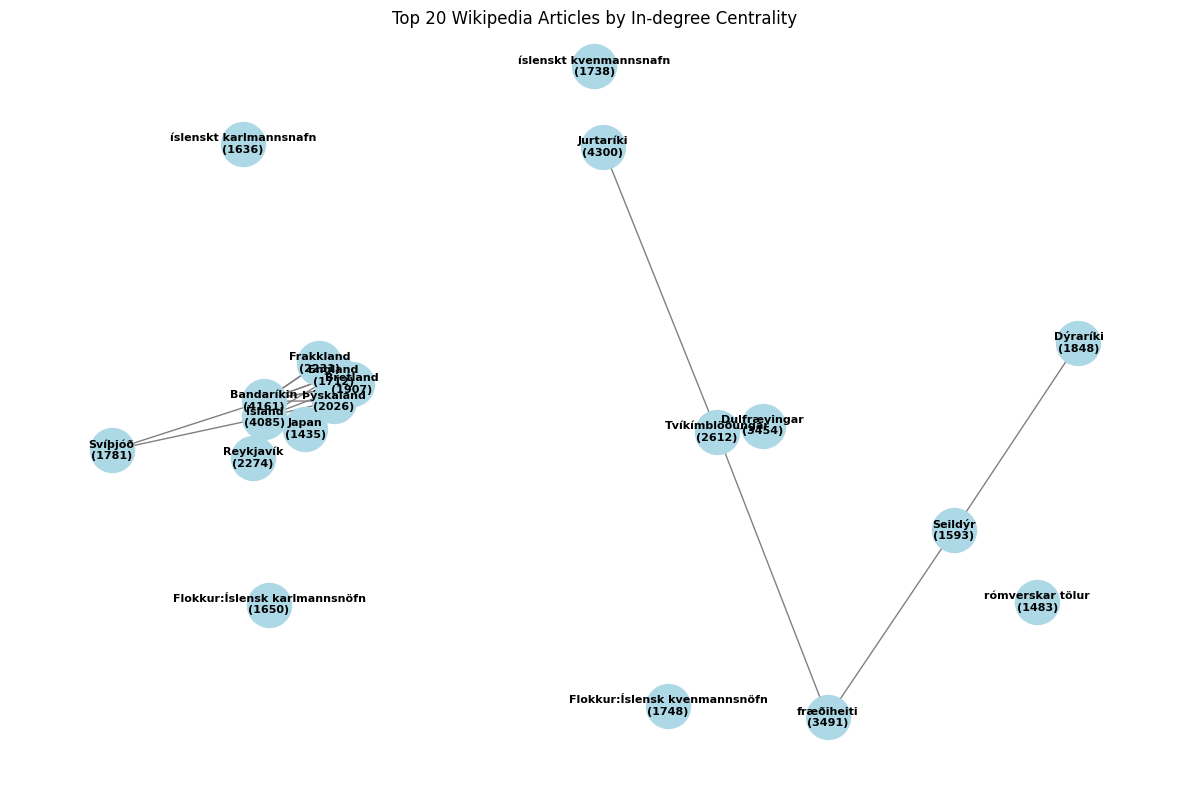

In [42]:
import networkx as nx
import matplotlib.pyplot as plt


def analyze_graph(graph):
    print("\nGraph Analysis:")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")

    # Degree centrality
    in_degree_centrality = nx.in_degree_centrality(graph)
    out_degree_centrality = nx.out_degree_centrality(graph)

    print("\nTop 20 articles by in-degree centrality (most linked-to):")
    top_articles = sorted(
        in_degree_centrality.items(), key=lambda x: x[1], reverse=True
    )[:20]

    for article, centrality in top_articles:
        in_links = graph.in_degree(article)  # Get the number of in-links
        print(f"{article}: centrality = {centrality:.4f}, in-links = {in_links}")

    print("\nTop 10 articles by out-degree centrality (most outgoing links):")
    for article, centrality in sorted(
        out_degree_centrality.items(), key=lambda x: x[1], reverse=True
    )[:10]:
        print(f"{article}: {centrality:.4f}")

    # PageRank
    pagerank = nx.pagerank(graph)
    print("\nTop 10 articles by PageRank:")
    for article, rank in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[
        :10
    ]:
        print(f"{article}: {rank:.6f}")

    # Strongly Connected Components
    largest_scc = max(nx.strongly_connected_components(graph), key=len)
    print(f"\nSize of the largest strongly connected component: {len(largest_scc)}")

    return top_articles


def plot_graph(graph, top_articles):
    subgraph = graph.subgraph([article for article, _ in top_articles])
    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(12, 8))

    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=1000, node_color="lightblue")

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edge_color="gray", arrows=True)

    # Draw labels
    labels = {node: f"{node}\n({graph.in_degree(node)})" for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8, font_weight="bold")

    plt.title("Top 20 Wikipedia Articles by In-degree Centrality")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Usage
# Assuming 'graph' is your NetworkX graph object
top_articles = analyze_graph(graph)
plot_graph(graph, top_articles)

In [38]:
pagerank = nx.pagerank(graph)


sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:3]

[('Flokkur:Íslensk kvenmannsnöfn', 0.0018414487305825767),
 ('íslenskt kvenmannsnafn', 0.0018342248027978494),
 ('Flokkur:Íslensk karlmannsnöfn', 0.001653736540134783)]

In [39]:
sorted(pagerank.items(), key=lambda x: x[1], reverse=False)[:3]

[('Landafræði Íslands', 2.0782929794316667e-06),
 ('Handelshøyskolen BI', 2.0782929794316667e-06),
 ('Jafnvægi', 2.0782929794316667e-06)]

In [40]:
graph["Flokkur:Íslensk kvenmannsnöfn"]

AtlasView({})